In [1]:
!pip install pinecone mplcursors --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.3/427.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 7.9 MB/s eta 0:00:00


In [2]:
#Import Necessary Libraries

import numpy as np
import pandas as pd
import ast
import torch
from tqdm import tqdm
import pinecone
import multiprocessing as mp
from transformers import CLIPProcessor, CLIPModel, CLIPVisionModelWithProjection, CLIPTextModelWithProjection
from PIL import Image
import os
from transformers import CLIPProcessor, CLIPModel, CLIPTextModel, CLIPTextModelWithProjection
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")
model.eval()

model_text = CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-base-patch16").to(device)
processor_text = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")
model_text.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

CLIPTextModelWithProjection(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerN

In [4]:
#Get Embeddings for User Query
def get_embeddings(query):
    text_inputs = processor(text=query, return_tensors="pt", padding=True, truncation = True)
    text_inputs = {k: v.to(device) for k, v in text_inputs.items()}  # Move text inputs to GPU
    # print(text_inputs['input_ids'])
    with torch.no_grad():
        # text_embeds = model.get_text_features(**text_inputs)
        # text_embeds = model(**text_inputs)
        # text_embeds = text_embeds.pooler_output
        # text_embeds = text_embeds.cpu()
        text_embeds = model_text(input_ids=text_inputs['input_ids'], attention_mask=text_inputs['attention_mask']).text_embeds
        # print(text_embeds
    return text_embeds

In [5]:
get_embeddings("red electric toothbrush").shape

torch.Size([1, 512])

In [ ]:
# df.loc[(df['Category'] == 'Health and Household', ['API Keys']]

In [6]:
#Function to Retrieve From Pinecone

def pinecone_retrieve(category, user_query, top_k, upload_strategy_file_path):

  df = pd.read_csv(upload_strategy_file_path)
  df.drop(columns=['Task Done (Yes/No)'], inplace = True)
  df = df.loc[(df['Type'] == 'add') | (df['Type'] == 'image only')]
  df = df.loc[df['Category'] == category]
  df = df.reset_index(drop = True)

  user_query_embedding = get_embeddings(user_query).detach().cpu()
  user_query_numpy = user_query_embedding.numpy()
  # if normalize_flag == 1:
  #   user_query_numpy = user_query_numpy/np.linalg.norm(user_query_numpy, ord=2, axis = 1)
  user_query_list = user_query_numpy.tolist()

  #Retrieve Image+Text
  pc_image_text = pinecone.Pinecone(api_key = df.loc[df['Type'] == 'add', ['API Keys']].values[0][0])

  index_image_text = pc_image_text.Index(df.loc[df['Type'] == 'add', ['Index Name']].values[0][0],
                  host = df.loc[df['Type'] == 'add', ['Host']].values[0][0])

  response = index_image_text.query(
      namespace="",
      vector= user_query_list[0],
      top_k = top_k, #How many vectors to retrieve
      include_values = True, #Return the actual vectors as well
      include_metadata=True,
      #filter={"genre": {"$eq": "action"}}
  )

  data = []
  for match in response['matches']:
      data.append({
          'id': match['id'],
          'score': match['score'],
          'vector': match['values'], #Add Vectors
          **match.get('metadata', {})# Add metadata if available
      })

  response_df_image_text = pd.DataFrame(data)
  response_df_image_text = response_df_image_text.sort_values(by = 'score', ascending = False)
  response_df_image_text = response_df_image_text.reset_index(drop = True)
  response_df_image_text['source'] = 'Text + Image'


  #Retrieve Image Only
  pc_image = pinecone.Pinecone(api_key = df.loc[df['Type'] == 'image only', ['API Keys']].values[0][0])

  index_image = pc_image.Index(df.loc[df['Type'] == 'image only', ['Index Name']].values[0][0],
                  host = df.loc[df['Type'] == 'image only', ['Host']].values[0][0])

  response = index_image.query(
      namespace="",
      vector= user_query_list[0],
      top_k = top_k, #How many vectors to retrieve
      include_values = True, #Return the actual vectors as well
      include_metadata=True,
      #filter={"genre": {"$eq": "action"}}
  )

  data = []
  for match in response['matches']:
      data.append({
          'id': match['id'],
          'score': match['score'],
          'vector': match['values'], #Add Vectors
          **match.get('metadata', {})# Add metadata if available
      })

  response_df_image = pd.DataFrame(data)
  response_df_image = response_df_image.sort_values(by = 'score', ascending = False)
  response_df_image = response_df_image.reset_index(drop = True)
  response_df_image['source'] = 'Image'


  response_df = pd.concat([response_df_image_text, response_df_image], axis = 0)
  response_df = response_df.sort_values(by = 'score', ascending = False)
  response_df = response_df.reset_index(drop = True)


  return user_query_list[0], response_df

In [8]:
# q, x = pinecone_retrieve(
#     index_name_image_text = 'health-household-add',
#     index_name_image = 'image-embeds-health-household',
#     host_url_image_text = 'https://health-household-add-yspnai5.svc.aped-4627-b74a.pinecone.io',
#     host_url_image = 'https://image-embeds-health-household-d1g0fdz.svc.aped-4627-b74a.pinecone.io',
#     api_key_image_text = '13e8cec3-814f-4035-9f4b-861c983d837c',
#     api_key_image = '42b77faa-1fbe-48e1-a625-1870dee3e5fd',
#     user_query = "Ray Ban sunglasses",
#     top_k = 10
# )

q, x = pinecone_retrieve(category = 'Health and Household',
                         user_query = "Ray Ban sunglasses",
                         top_k = 10,
                         upload_strategy_file_path = '/content/Pinecone Upload Strategy.csv')

x

,id,score,vector,description,image_url,parent_asin,text_image_cosine_similarity,title,source,image_type
0,B00EC0B3F0,0.683390,"[0.187304541, 0.221720666, -0.0574770346, 0.25...",Combine the protection of sunglasses and the f...,https://m.media-amazon.com/images/I/41wRF3QkPP...,B00EC0B3F0,0.318036,+1.50 Reading Glasses / Sun Glasses Aviator St...,Text + Image,NaN
1,B004XG53OU,0.670079,"[0.0168953836, -0.262720942, -0.366130531, -0....",Ray-Ban Ophthalmic 5121 A classic wayfarer for...,https://m.media-amazon.com/images/I/41KyQi2Swy...,B004XG53OU,0.335241,Ray-Ban Glasses 5121 Tortoise 2012 50mm,Text + Image,NaN
2,B078G45SM3,0.664250,"[0.185152367, -0.0671528131, -0.146857858, -0....",Retro style designed with longer flexible temp...,https://m.media-amazon.com/images/I/31RKDvB45W...,B078G45SM3,0.303690,Full Lens Reading Sunglasses R57,Text + Image,NaN
3,B0049SJ1G8,0.662605,"[0.00784471631, -0.207033649, -0.378596753, -0...",Ray-Ban Ophthalmic 5227 Keep things cool with ...,https://m.media-amazon.com/images/I/31ChUlk-c6...,B0049SJ1G8,0.366886,Ray-Ban Glasses 5227 Tortoise 5029 52,Text + Image,NaN
4,B07CH3WP1Y,0.661972,"[0.197669238, -0.221409217, -0.174183726, -0.0...","DISCOVER THE EYEKEPPER DIFFERENCE, Provide the...",https://m.media-amazon.com/images/I/31o+1fnCsI...,B07CH3WP1Y,0.310603,Eyekepper Bifocal Sunglasses Reading Sunglasses,Text + Image,NaN
5,B00815KJY8,0.655162,"[0.251052946, -0.195848703, -0.251937926, -0.0...",A new range of Reading Sunglasses. For men and...,https://m.media-amazon.com/images/I/31oMLuJ58i...,B00815KJY8,0.329280,"ilovemyreadingglasses ""Wayfarer style reading ...",Text + Image,NaN
6,B08JCCZNXD,0.654671,"[0.393375367, -0.405171782, -0.43612197, -0.13...",ephiu sunglasses,https://m.media-amazon.com/images/I/01RmK+J4pJ...,B08JCCZNXD,0.223902,EPHIU sunglasses 6,Text + Image,NaN
7,B07V48Y4F4,0.653692,"[0.120292902, -0.298669636, -0.126203299, 0.00...",Stylish and lightweight sun readers provide pr...,https://m.media-amazon.com/images/I/31CkSnVvUr...,B07V48Y4F4,0.304031,Phoenix Square Full Reader Sunglasses,Text + Image,NaN
8,B08FRTZTBL,0.652874,"[0.132397696, 0.0858142823, -0.206335783, -0.1...",Specifications: Frame Material: Metal Frame Sp...,https://m.media-amazon.com/images/I/31roTa30EY...,B08FRTZTBL,0.329671,EYE ZOOM Aviator Style Blue Light Blocking Bif...,Text + Image,NaN
9,B08FLWQR7K,0.652874,"[0.132397696, 0.0858142823, -0.206335783, -0.1...",Specifications: Frame Material: Metal Frame Sp...,https://m.media-amazon.com/images/I/31roTa30EY...,B08FLWQR7K,0.329671,EYE ZOOM Aviator Style Blue Light Blocking Bif...,Text + Image,NaN


In [9]:
#Attention Calculation

import torch
import torch.nn.functional as F

def attention_calc_weights(user_query_list, response_df):
  Q = torch.tensor(user_query_list) #Shape 1x512
  K = torch.stack([torch.tensor(response_df.loc[i, 'vector']) for i in range(len(response_df))]) #Shape 2x512

  # Q = Q/Q.norm(dim=-1, keepdim=True)
  # K = K/K.norm(dim=1, keepdim=True)

  # Q = Q/torch.linalg.norm(Q, ord=2, dim=0, keepdim=True).clamp(min=1e-8)
  # K = K/torch.linalg.norm(K, ord=2, dim=1, keepdim=True).clamp(min=1e-8)

  d_k = Q.size(-1)

  scores = torch.matmul(Q, K.T) / d_k**0.5  # Shape: (20) ----> Normalized Attention Scores
  # scores = torch.norm(Q+K, dim=1, p=2)  # Shape: (20) ---> Scores is the difference/sum between Q and K

  attn_output_weights = F.softmax(scores, dim=-1)
  attn_output_weights = attn_output_weights.squeeze(0)

  attn_output_weights_list = attn_output_weights.tolist()

  for idx in range(len(attn_output_weights_list)):
    response_df.loc[idx, 'attn_weight'] = attn_output_weights_list[idx]

  response_df = response_df.sort_values(by = 'attn_weight', ascending = False)
  response_df = response_df.reset_index(drop = True)

  return attn_output_weights, response_df

In [10]:
attn_weights, x_1 = attention_calc_weights(q, x)
x_1

,id,score,vector,description,image_url,parent_asin,text_image_cosine_similarity,title,source,image_type,attn_weight
0,B078G45SM3,0.664250,"[0.185152367, -0.0671528131, -0.146857858, -0....",Retro style designed with longer flexible temp...,https://m.media-amazon.com/images/I/31RKDvB45W...,B078G45SM3,0.303690,Full Lens Reading Sunglasses R57,Text + Image,NaN,0.072447
1,B07V48Y4F4,0.653692,"[0.120292902, -0.298669636, -0.126203299, 0.00...",Stylish and lightweight sun readers provide pr...,https://m.media-amazon.com/images/I/31CkSnVvUr...,B07V48Y4F4,0.304031,Phoenix Square Full Reader Sunglasses,Text + Image,NaN,0.070762
2,B07CH3WP1Y,0.661972,"[0.197669238, -0.221409217, -0.174183726, -0.0...","DISCOVER THE EYEKEPPER DIFFERENCE, Provide the...",https://m.media-amazon.com/images/I/31o+1fnCsI...,B07CH3WP1Y,0.310603,Eyekepper Bifocal Sunglasses Reading Sunglasses,Text + Image,NaN,0.068832
3,B08JCCZNXD,0.654671,"[0.393375367, -0.405171782, -0.43612197, -0.13...",ephiu sunglasses,https://m.media-amazon.com/images/I/01RmK+J4pJ...,B08JCCZNXD,0.223902,EPHIU sunglasses 6,Text + Image,NaN,0.065361
4,B00EC0B3F0,0.683390,"[0.187304541, 0.221720666, -0.0574770346, 0.25...",Combine the protection of sunglasses and the f...,https://m.media-amazon.com/images/I/41wRF3QkPP...,B00EC0B3F0,0.318036,+1.50 Reading Glasses / Sun Glasses Aviator St...,Text + Image,NaN,0.063720
5,B004XG53OU,0.670079,"[0.0168953836, -0.262720942, -0.366130531, -0....",Ray-Ban Ophthalmic 5121 A classic wayfarer for...,https://m.media-amazon.com/images/I/41KyQi2Swy...,B004XG53OU,0.335241,Ray-Ban Glasses 5121 Tortoise 2012 50mm,Text + Image,NaN,0.063383
6,B00815KJY8,0.655162,"[0.251052946, -0.195848703, -0.251937926, -0.0...",A new range of Reading Sunglasses. For men and...,https://m.media-amazon.com/images/I/31oMLuJ58i...,B00815KJY8,0.329280,"ilovemyreadingglasses ""Wayfarer style reading ...",Text + Image,NaN,0.062148
7,B08FRTZTBL,0.652874,"[0.132397696, 0.0858142823, -0.206335783, -0.1...",Specifications: Frame Material: Metal Frame Sp...,https://m.media-amazon.com/images/I/31roTa30EY...,B08FRTZTBL,0.329671,EYE ZOOM Aviator Style Blue Light Blocking Bif...,Text + Image,NaN,0.061421
8,B08FLWQR7K,0.652874,"[0.132397696, 0.0858142823, -0.206335783, -0.1...",Specifications: Frame Material: Metal Frame Sp...,https://m.media-amazon.com/images/I/31roTa30EY...,B08FLWQR7K,0.329671,EYE ZOOM Aviator Style Blue Light Blocking Bif...,Text + Image,NaN,0.061421
9,B0049SJ1G8,0.662605,"[0.00784471631, -0.207033649, -0.378596753, -0...",Ray-Ban Ophthalmic 5227 Keep things cool with ...,https://m.media-amazon.com/images/I/31ChUlk-c6...,B0049SJ1G8,0.366886,Ray-Ban Glasses 5227 Tortoise 5029 52,Text + Image,NaN,0.060310


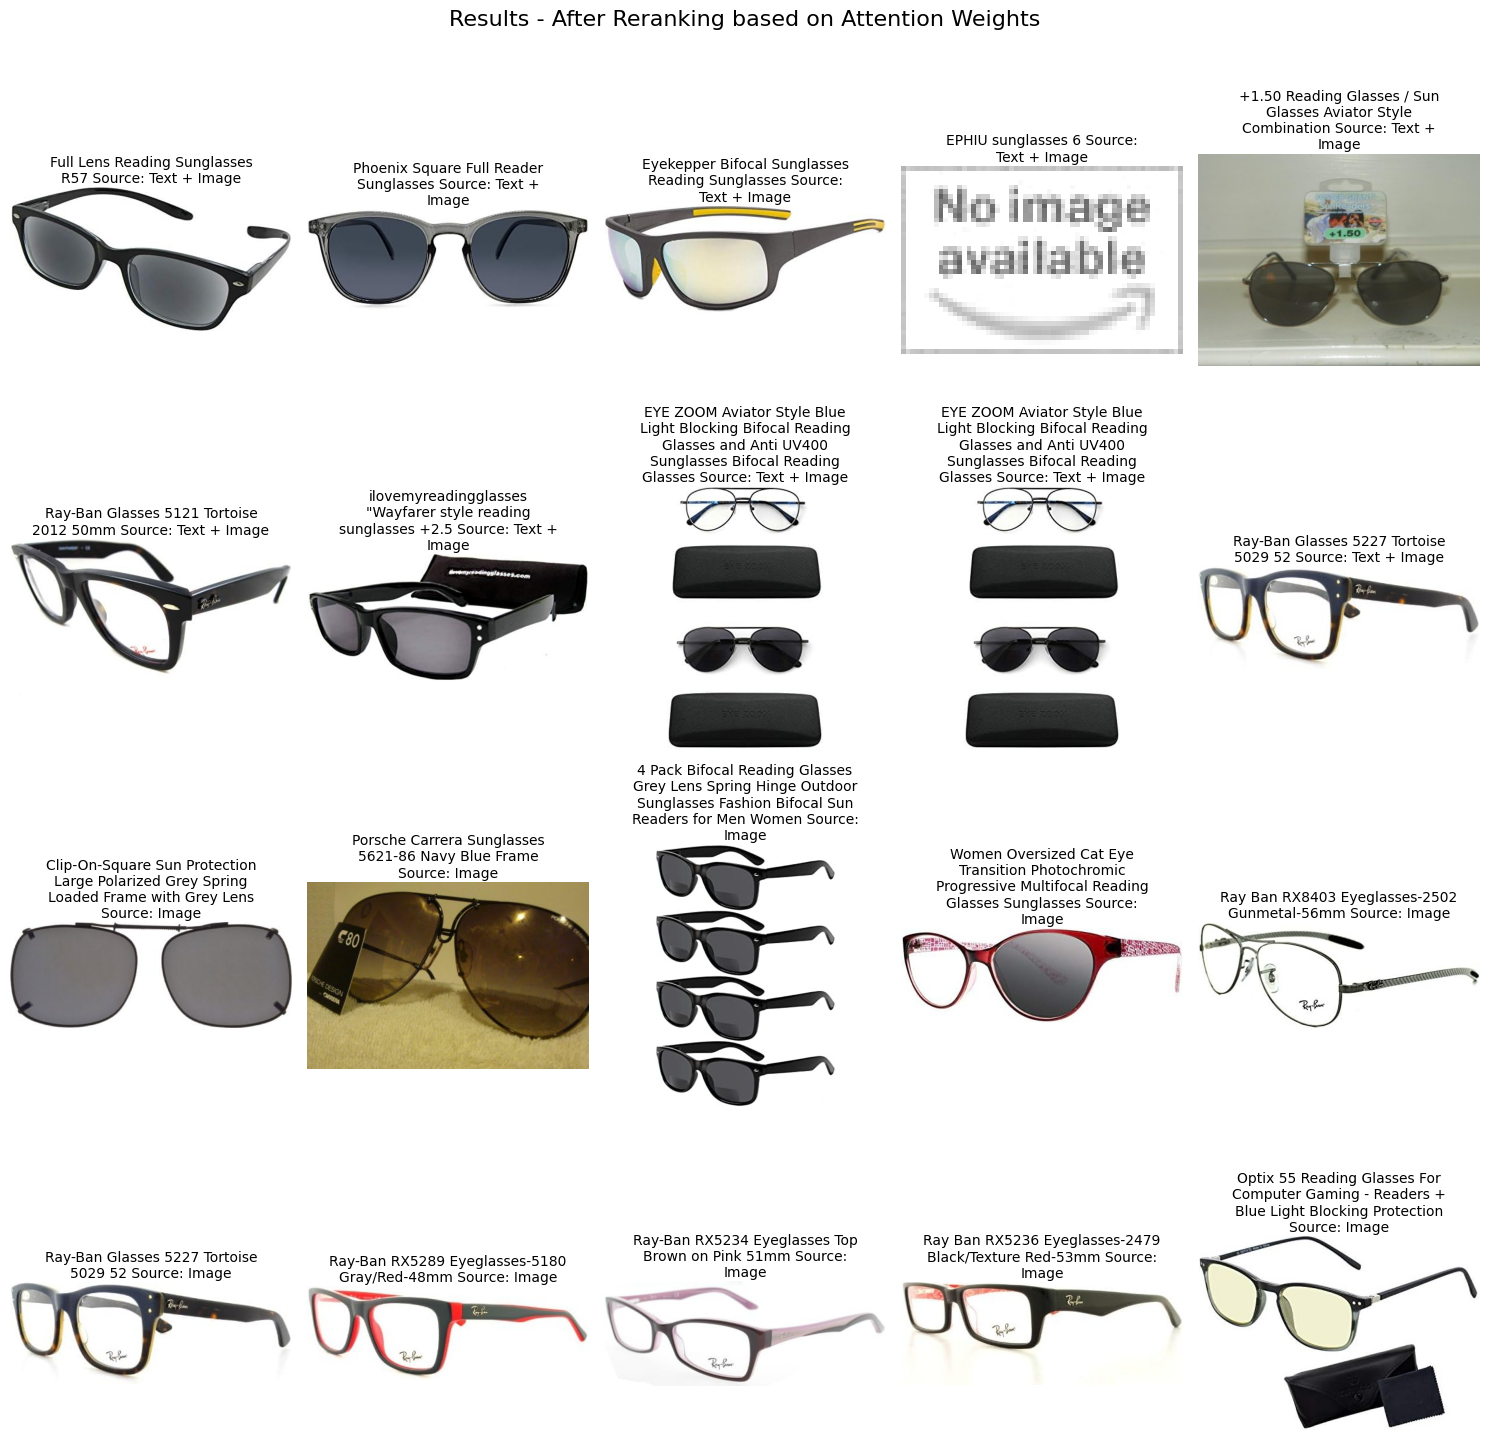

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
import textwrap
import mplcursors

def plot_product_recommendations(df, title):
    """
    Plots product recommendations in a 2x5 grid from a DataFrame containing
    image URLs and product titles with hover functionality for descriptions.

    Parameters:
    df (pd.DataFrame): DataFrame with 'image_url', 'title', and 'description' columns.
    title (str): Main title for the plot.
    """
    # Check if DataFrame has the required columns
    if not all(col in df.columns for col in ['image_url', 'title', 'description']):
        raise ValueError("DataFrame must contain 'image_url', 'title', and 'description' columns.")

    # Create a 4x5 grid
    fig, axs = plt.subplots(4, 5, figsize=(15, 15))
    fig.suptitle(title, fontsize=16)

    # Loop through the grid and fill it with images and titles
    for ax, (index, row) in zip(axs.flatten(), df.iterrows()):
        # Fetch the image from the URL
        try:
            response = requests.get(row['image_url'])
            img = Image.open(BytesIO(response.content))
        except Exception as e:
            print(f"Error loading image at index {index}: {e}")
            img = np.random.rand(10, 10, 3)  # Use a random image if loading fails

        ax.imshow(img)

        # Wrap the title to avoid overlapping
        wrapped_title = textwrap.fill(row['title']+' Source: '+row['source'], width=30)  # Adjust the width as needed
        ax.set_title(wrapped_title, fontsize=10, pad=3)  # Added pad for spacing
        ax.axis('off')  # Hide the axes

    # Adjust layout to prevent overlap
    plt.subplots_adjust(hspace=0.4, wspace=0.3)  # Increase spacing between plots
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title

    # Create interactive cursor to display descriptions on hover
    cursor = mplcursors.cursor(axs.flatten(), hover=True)

    # Set hover behavior to show the product description
    @cursor.connect("add")
    def on_add(sel):
        sel.annotation.set_text(df['description'].iloc[sel.index])
        sel.annotation.get_bbox().set_facecolor('white')
        sel.annotation.get_bbox().set_alpha(0.8)

    plt.show()



# Call the function
plot_product_recommendations(x_1, 'Results - After Reranking based on Attention Weights')


In [12]:
x_2 = x.sort_values(by = 'text_image_cosine_similarity', ascending = False)
x_2 = x_2.reset_index(drop = True)
x_2

,id,score,vector,description,image_url,parent_asin,text_image_cosine_similarity,title,source,image_type,attn_weight
0,B004SHCKQI,0.322454,"[-0.201383218, -0.24229382, -0.0190223232, 0.2...",Ray-Ban eyeglasses are one of the most recogni...,https://m.media-amazon.com/images/I/31NxMWpCA0...,B004SHCKQI,0.372239,Ray-Ban RX5234 Eyeglasses Top Brown on Pink 51mm,Image,Valid Image,0.033825
1,B00BD99NS2,0.337393,"[-0.176543623, 0.00173017383, -0.365760058, 0....",Ray Ban 0RX5289 demo lens 5180 48X17X135 Style...,https://m.media-amazon.com/images/I/312nBN919Q...,B00BD99NS2,0.371047,Ray-Ban RX5289 Eyeglasses-5180 Gray/Red-48mm,Image,Valid Image,0.034836
2,B0049SJ1G8,0.662605,"[0.00784471631, -0.207033649, -0.378596753, -0...",Ray-Ban Ophthalmic 5227 Keep things cool with ...,https://m.media-amazon.com/images/I/31ChUlk-c6...,B0049SJ1G8,0.366886,Ray-Ban Glasses 5227 Tortoise 5029 52,Text + Image,NaN,0.060310
3,B0049SJ1G8,0.336916,"[-0.304249942, -0.164124161, -0.424494505, 0.1...",Ray-Ban Ophthalmic 5227 Keep things cool with ...,https://m.media-amazon.com/images/I/31ChUlk-c6...,B0049SJ1G8,0.366886,Ray-Ban Glasses 5227 Tortoise 5029 52,Image,Valid Image,0.035091
4,B003EEWYWQ,0.334656,"[-0.155907378, -0.0795235261, 0.0950581878, -0...",Ray Ban 0RX8403 demo lens 2502 56X14X140 Style...,https://m.media-amazon.com/images/I/31JwnPnfky...,B003EEWYWQ,0.347182,Ray Ban RX8403 Eyeglasses-2502 Gunmetal-56mm,Image,Valid Image,0.035189
5,B004XG53OU,0.670079,"[0.0168953836, -0.262720942, -0.366130531, -0....",Ray-Ban Ophthalmic 5121 A classic wayfarer for...,https://m.media-amazon.com/images/I/41KyQi2Swy...,B004XG53OU,0.335241,Ray-Ban Glasses 5121 Tortoise 2012 50mm,Text + Image,NaN,0.063383
6,B004SHOKR0,0.331367,"[-0.0681040287, -0.257074, -0.37696296, 0.4090...",RAY-BAN VISTA RX5236 2479 TOP BLACK ON TEXTURE...,https://m.media-amazon.com/images/I/31BxGgECkr...,B004SHOKR0,0.332358,Ray Ban RX5236 Eyeglasses-2479 Black/Texture R...,Image,Valid Image,0.033173
7,B08FRTZTBL,0.652874,"[0.132397696, 0.0858142823, -0.206335783, -0.1...",Specifications: Frame Material: Metal Frame Sp...,https://m.media-amazon.com/images/I/31roTa30EY...,B08FRTZTBL,0.329671,EYE ZOOM Aviator Style Blue Light Blocking Bif...,Text + Image,NaN,0.061421
8,B08FLWQR7K,0.652874,"[0.132397696, 0.0858142823, -0.206335783, -0.1...",Specifications: Frame Material: Metal Frame Sp...,https://m.media-amazon.com/images/I/31roTa30EY...,B08FLWQR7K,0.329671,EYE ZOOM Aviator Style Blue Light Blocking Bif...,Text + Image,NaN,0.061421
9,B00815KJY8,0.655162,"[0.251052946, -0.195848703, -0.251937926, -0.0...",A new range of Reading Sunglasses. For men and...,https://m.media-amazon.com/images/I/31oMLuJ58i...,B00815KJY8,0.329280,"ilovemyreadingglasses ""Wayfarer style reading ...",Text + Image,NaN,0.062148


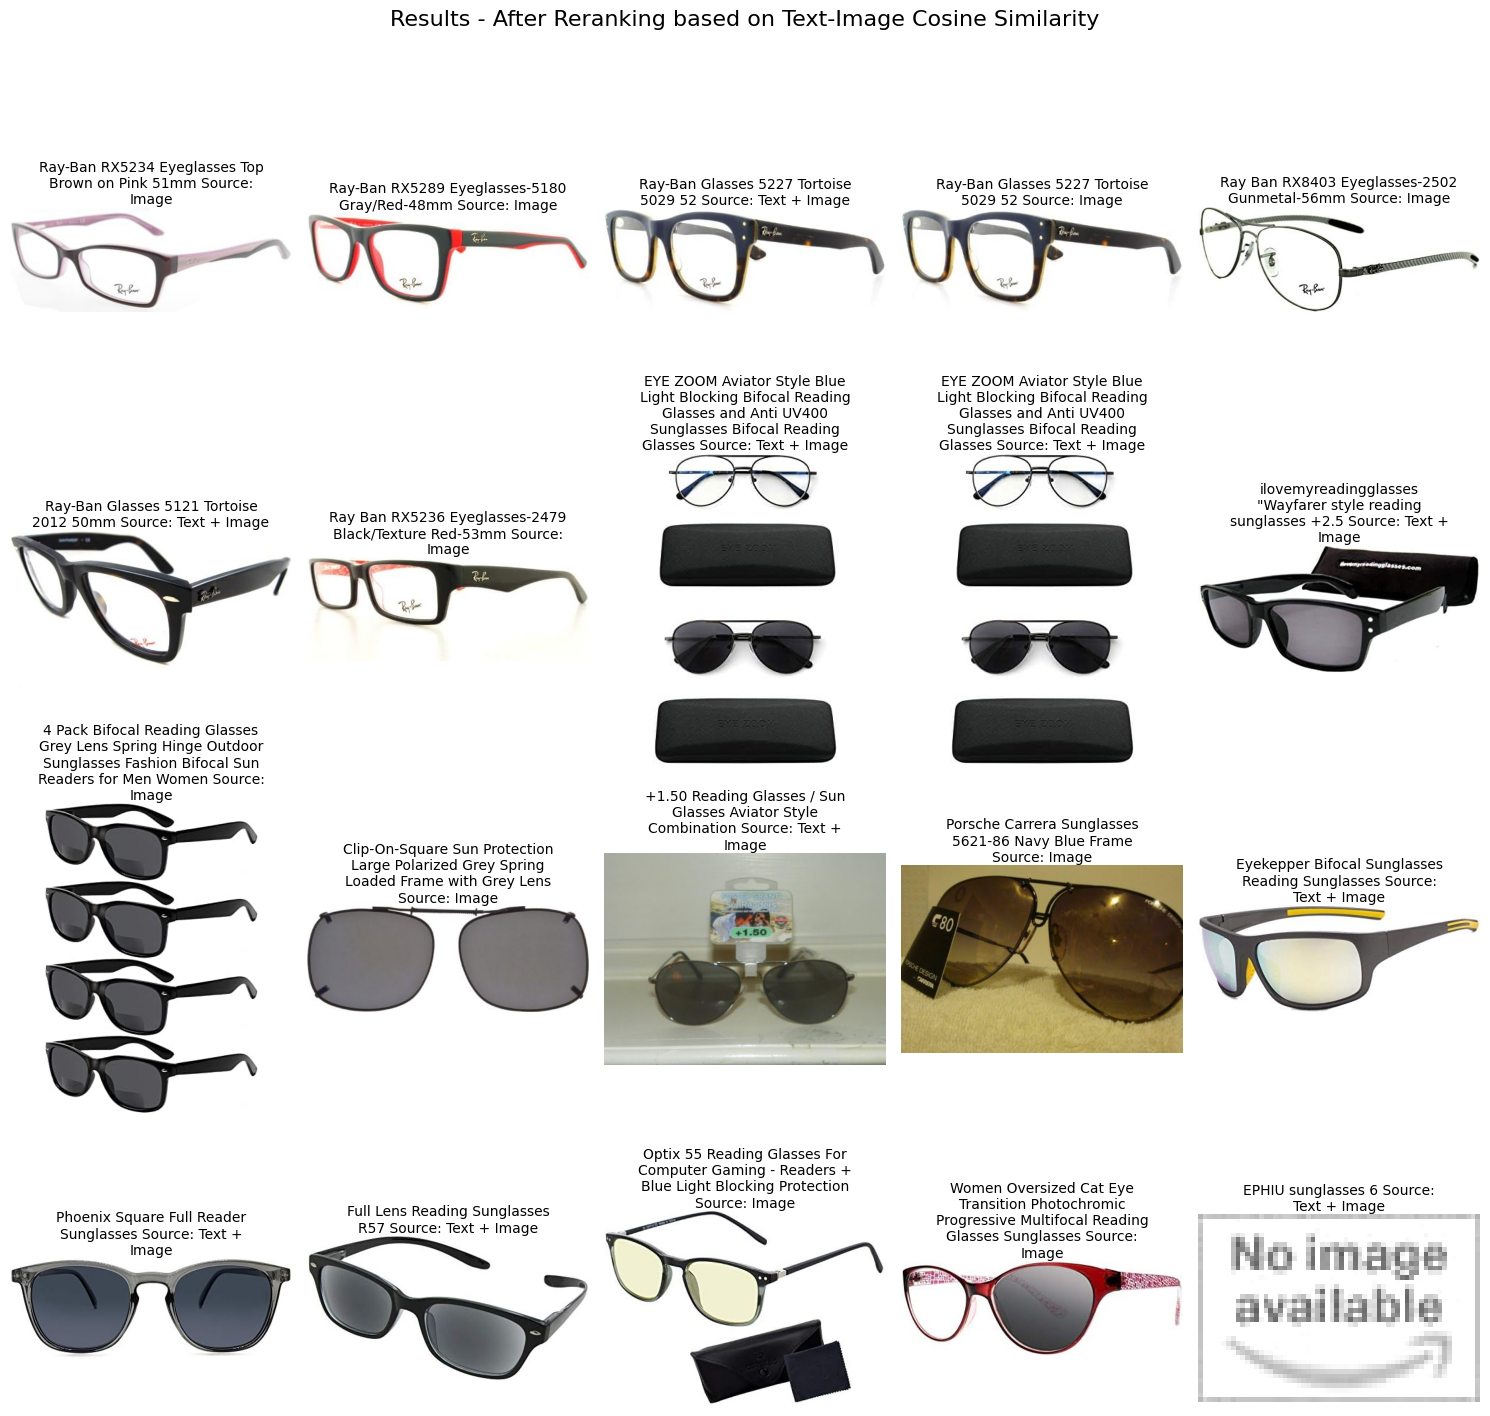

In [13]:
plot_product_recommendations(x_2, 'Results - After Reranking based on Text-Image Cosine Similarity')

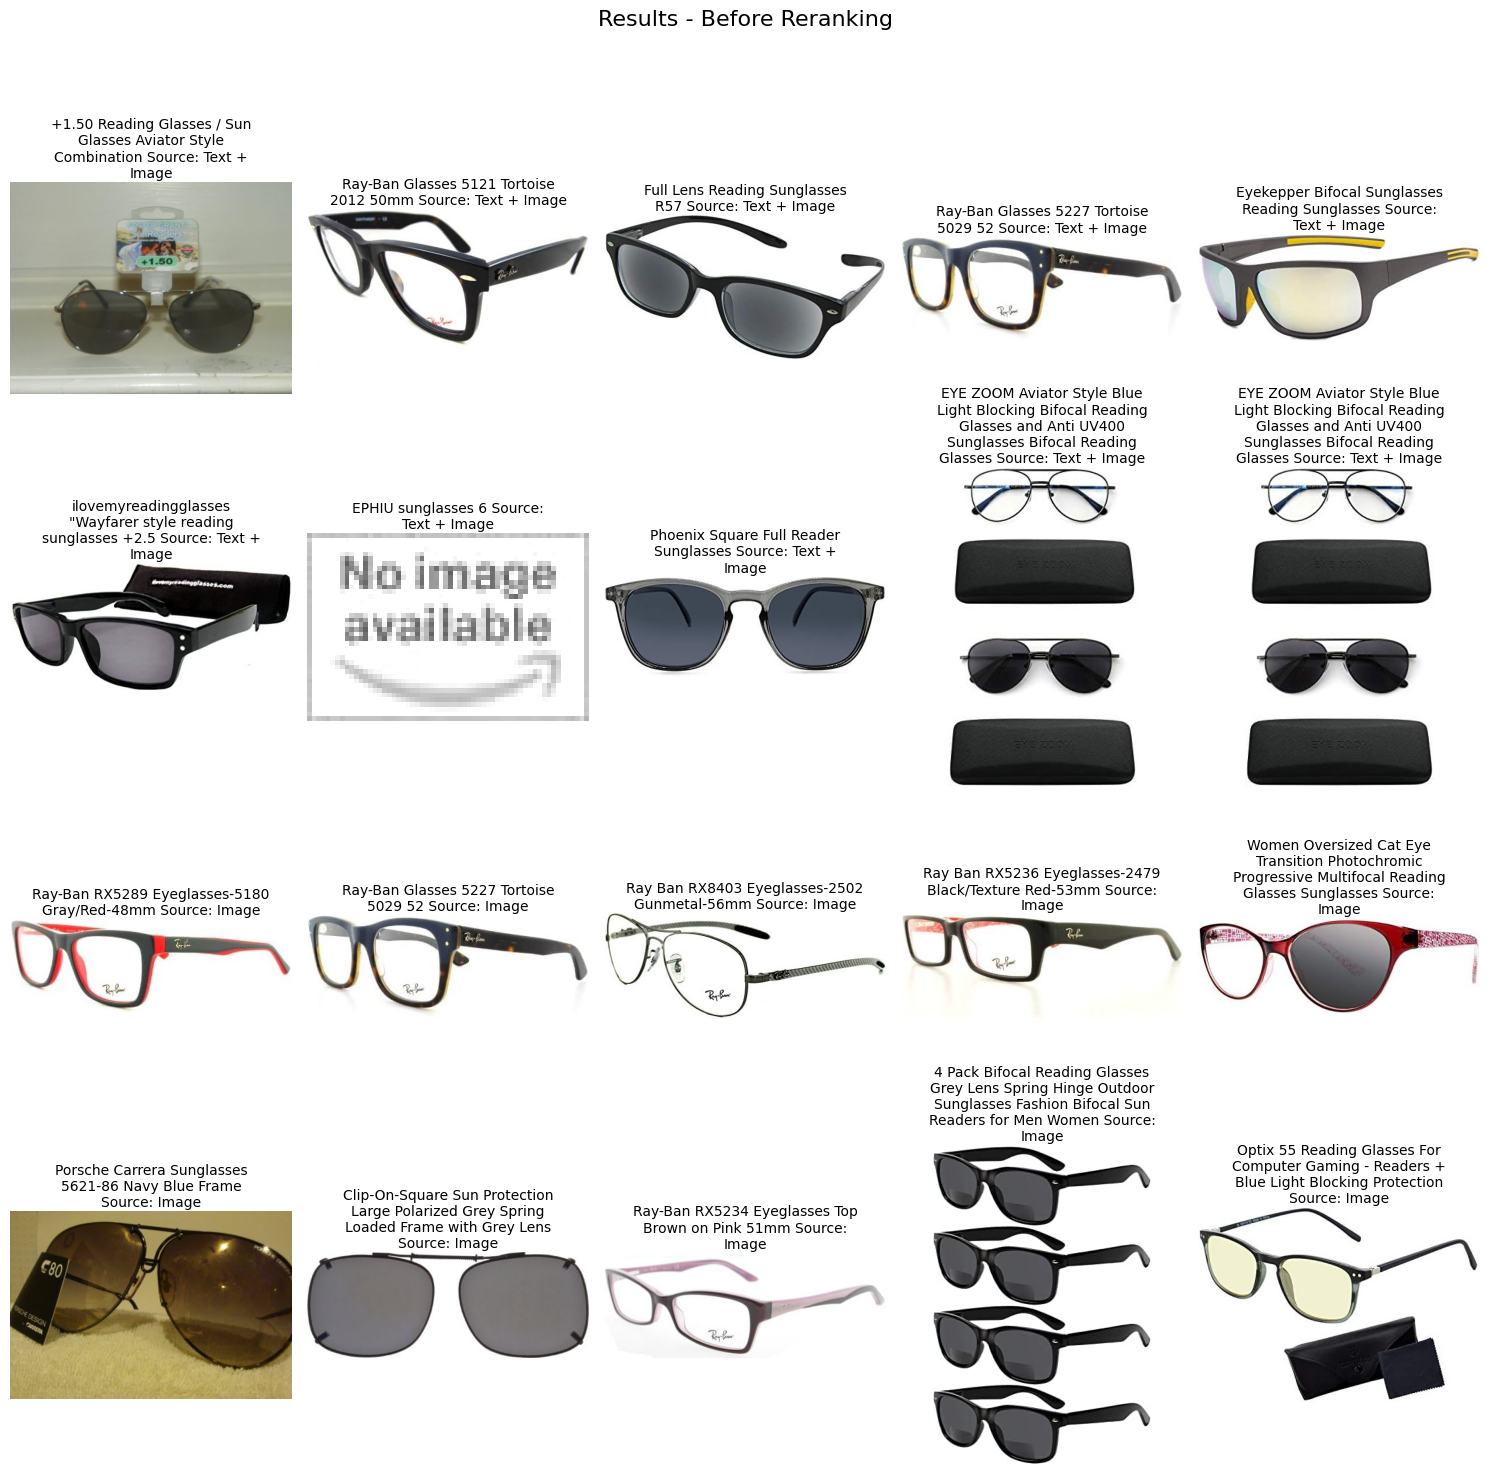

In [14]:
plot_product_recommendations(x, 'Results - Before Reranking')

In [15]:
from transformers import pipeline
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from collections import Counter


classifier = pipeline("zero-shot-classification",
                      model="knowledgator/comprehend_it-base")


text = "Anti-UV Sunglasses"

words = text.split()
words = [word for word in words if word.lower() not in stopwords.words('english')] #Remove Stopwords


candidate_labels = ['feeling or adjective or quality', 'animal or color or shape or object']

scores = []

for word in words:
  results = classifier(word, candidate_labels)
  print(results)
  scores.append(results)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


config.json:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/738M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


{'sequence': 'Anti-UV', 'labels': ['feeling or adjective or quality', 'animal or color or shape or object'], 'scores': [0.6428332924842834, 0.35716673731803894]}
{'sequence': 'Sunglasses', 'labels': ['animal or color or shape or object', 'feeling or adjective or quality'], 'scores': [0.8624424338340759, 0.13755756616592407]}


In [16]:
print(words)

scores

['Anti-UV', 'Sunglasses']


[{'sequence': 'Anti-UV',
  'labels': ['feeling or adjective or quality',
   'animal or color or shape or object'],
  'scores': [0.6428332924842834, 0.35716673731803894]},
 {'sequence': 'Sunglasses',
  'labels': ['animal or color or shape or object',
   'feeling or adjective or quality'],
  'scores': [0.8624424338340759, 0.13755756616592407]}]

In [33]:
def get_most_frequent_label(query, candidate_labels, print_flag = 1):
    """
    Processes a query to classify its components and returns the most frequent label.

    Args:
        query (str): The input text to classify.
        candidate_labels (list): The list of candidate labels for classification.

    Returns:
        str: The most frequent label in the query based on classification results.
    """
    # Split words and remove stopwords
    words = query.split()
    words = [word for word in words if word.lower() not in stopwords.words('english')]

    # Classify each word and collect labels
    labels = []
    for word in words:
        results = classifier(word, candidate_labels)
        if print_flag == 1:
          print(results)
        labels.append(results['labels'][0])

    # Calculate the most frequent label
    label_counts = Counter(labels)
    #print('label_counts: ', label_counts)
    most_frequent_label = label_counts.most_common(1)[0][0]  # Get the most frequent label

    if most_frequent_label == candidate_labels[0]:
      return True
    else:
      return False

In [36]:
# Example usage
query = "red travel-sized electric toothbrush kit"
candidate_labels = ['feeling or adjective or quality', 'animal or color or shape or object']

flag_perform_weighted_sum = get_most_frequent_label(query, candidate_labels, 1)
print("flag_perform_weighted_sum:", flag_perform_weighted_sum)

{'sequence': 'red', 'labels': ['animal or color or shape or object', 'feeling or adjective or quality'], 'scores': [0.7965206503868103, 0.20347929000854492]}
{'sequence': 'travel-sized', 'labels': ['animal or color or shape or object', 'feeling or adjective or quality'], 'scores': [0.8490812182426453, 0.1509188413619995]}
{'sequence': 'electric', 'labels': ['animal or color or shape or object', 'feeling or adjective or quality'], 'scores': [0.6450545787811279, 0.35494545102119446]}
{'sequence': 'toothbrush', 'labels': ['animal or color or shape or object', 'feeling or adjective or quality'], 'scores': [0.8282793164253235, 0.1717206835746765]}
{'sequence': 'kit', 'labels': ['animal or color or shape or object', 'feeling or adjective or quality'], 'scores': [0.9264594316482544, 0.07354053854942322]}
flag_perform_weighted_sum: False


In [37]:
#All in One Retrieval Process
def get_recs(user_query, category, candidate_labels, top_k, upload_strategy_file_path, plot_flag = 1):
  q, x = pinecone_retrieve(category = category,
                          user_query = user_query,
                          top_k = top_k,
                          upload_strategy_file_path = upload_strategy_file_path)

  flag_perform_weighted_sum = get_most_frequent_label(user_query, candidate_labels, 0)

  if flag_perform_weighted_sum == True:
    # Filter the DataFrame for the two product categories
    text_image_prods = x[x['source'] == 'Text + Image']
    image_only_prods = x[x['source'] == 'Image']

    # Perform the weighted sum of scores
    text_image_scores = 0.25 * text_image_prods['score']
    image_only_scores = 0.75 * image_only_prods['score']

    # print(text_image_scores)
    # Add the weighted scores as a new column in their respective DataFrames
    text_image_prods = text_image_prods.assign(weighted_scores=text_image_scores)
    image_only_prods = image_only_prods.assign(weighted_scores=image_only_scores)

    # Combine the two DataFrames
    combined_df = pd.concat([text_image_prods, image_only_prods])

    # Sort the combined DataFrame by weighted scores in descending order
    sorted_combined_df = combined_df.sort_values(by='weighted_scores', ascending=False)
    sorted_combined_df = sorted_combined_df.reset_index(drop = True)

    # Display the sorted DataFrame
    #print(sorted_combined_df)
    if plot_flag == 1:
      plot_product_recommendations(sorted_combined_df, 'Weighted combination')
    return q, sorted_combined_df


  else:
      # Show image-only products
      image_only_prods = x[x['source'] == 'Image']
      image_only_prods = image_only_prods.reset_index(drop = True)

      if plot_flag == 1:
        plot_product_recommendations(image_only_prods, 'Image only Recommendations')
      return q, image_only_prods


In [38]:
q_embedding, result_df = get_recs(user_query = "Leather Office Chair",
         category = 'Health and Household',
         top_k = 10,
         upload_strategy_file_path = '/content/Pinecone Upload Strategy.csv',
         candidate_labels = ['feeling or adjective or quality', 'animal or color or shape or object'],
         plot_flag = 0)

## Clustering Based Evaluation - Only For 1 Category (Health and Household)

In [44]:
df_list = []

embeddings_path = '/content/'
for filename in os.listdir(embeddings_path):
    if filename.endswith('.parquet'):
        file_path = os.path.join(embeddings_path, filename)
        df = pd.read_parquet(file_path)
        df_list.append(df)

df = pd.concat(df_list, ignore_index=True)
df = df[df['similarity'] >= 0.2]
df = df.reset_index(drop = True)
df

,parent_asin,title,description,image_url,tokenized_text,tokenized_image,similarity
0,B0BBFXMB3K,MAYIWO Aocate Dial Adjustable Glasses Variable...,Our reading eyewear is the fully adjustable ey...,https://m.media-amazon.com/images/I/51PHb7qHWz...,"[0.185804, 0.05988825, -0.21222566, -0.3175825...","[-0.22087184, -0.34813482, -0.17542818, 0.0144...",0.317527
1,B00020HX5S,"Kal 100 Mcg Selenium Yeast Free Tablets, 100 C...","Yeast free, fast acting, dietary supplement. S...",https://m.media-amazon.com/images/I/41+o7jz057...,"[-0.27454498, -0.37010396, 0.1804463, -0.09722...","[-0.5216162, 0.73516864, 0.1014123, -0.0208085...",0.380227
2,B083HSF77X,READING GLASSES 5 pack Ladies Small Lenses Pol...,"Size for manual measurement,there may be a 0 t...",https://m.media-amazon.com/images/I/51wt2NcUMo...,"[0.060211316, -0.049320824, -0.19240117, -0.13...","[-0.42617983, 0.23766313, -0.052928783, 0.0522...",0.371207
3,B0788347PH,Embargo Shop Original Unisex Leather Short Cig...,Buy a wonderful fashion accessory & Keep away ...,https://m.media-amazon.com/images/I/41WAqldS9z...,"[0.11220613, 0.14898674, -0.21954493, 0.193115...","[-0.2403934, 0.14798215, 0.34174806, -0.045128...",0.356268
4,B0992WQFPQ,VITENZI Sunglasses with Readers for Women Tint...,The Gela Librarian Style Bifocal Reading Sungl...,https://m.media-amazon.com/images/I/419pJT-sis...,"[0.239692, -0.13572721, -0.17195648, -0.303233...","[0.21173967, -0.42359176, 0.028218597, 0.05172...",0.306255
...,...,...,...,...,...,...,...
409912,B002VWK0FK,"Drive Medical Designer Series""T"" Handle Cane w...","If you are looking for comfort and style, look...",https://m.media-amazon.com/images/I/31DhIlnqwC...,"[-0.23449948, 0.15051006, -0.18603423, -0.0949...","[0.4466866, 0.5656847, 0.13144895, -0.14597596...",0.303633
409913,B07L33R14P,"Linkfar Microlet Lancets for Blood Testing,300...",💎 Our lancets are designed for a more comforta...,https://m.media-amazon.com/images/I/41ID3KGkbL...,"[-0.38773477, -0.14589426, 0.7648661, -0.21987...","[-0.3329223, 0.22147869, 1.1877921, -0.2912493...",0.410360
409914,B007SUDVQ0,"Little Busy Bodies LLC Boogie Wipes, Fresh Sce...",Saline nose wipes are designed to dissolve muc...,https://m.media-amazon.com/images/I/51D34oDiVR...,"[0.25210023, -0.1609375, -0.21070579, -0.00881...","[0.47338122, -0.0058585703, 0.23439321, -0.383...",0.326321
409915,B000OO1NH6,Source Naturals Coenzymated B-2 25mg - Quick D...,In order for vitamins to be utilized by the bo...,https://m.media-amazon.com/images/I/41mhw81JK8...,"[-0.008262956, -0.12092209, 0.25764093, -0.124...","[-0.20830612, 0.0752849, 0.41128927, 0.1144317...",0.372303
